[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alexwolson/carte-biozone-workshop/blob/main/Lab-2-1.ipynb)

# CARTE-BioZone Workshop on Machine Learning
#### Tuesday, August 29, 2023
#### Lab 1, Day 2: Decision Trees
##### Lab author: Alex Olson

#### Introduction

In [1]:
# Check if we are running on Google Colab, or locally
import sys

IN_COLAB = "google.colab" in sys.modules

In [2]:
if not IN_COLAB:  # Colab already has these installed
    !pip install -q numpy scikit-learn pandas
# Always need to install xgboost and shap
!pip install -q xgboost shap

In [3]:
# Import standard libraries
import pandas as pd
import numpy as np

# Import scikit-learn libraries for data handling and preprocessing
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import preprocessing

# Import tree-based classifiers
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Import other boosting classifier
from xgboost import XGBClassifier

In [4]:
# Sometimes Graphviz is a pain to install. This worksheet will work without it, but you won't be able to visualize the trees
try:
    import graphviz
    from sklearn.tree import export_graphviz

    graphviz_installed = True
except:
    print("Graphviz is not installed. You will not be able to visualize the trees")
    graphviz_installed = False

Graphviz is not installed. You will not be able to visualize the trees


### Decision Trees

Decision trees are popular supervised learning methods used for classification and regression. The tree represents a series of simple decision rules that predict the target when the feature vector is passed through them. Decision trees are easy to understand, can be visualized nicely, require very little data preparation (e.g., we don't need to scale features), and the trained model can be explained easily to others post priori (as opposed to other *black box* methods that are difficult to communicate).

###### Example
Suppose you wanted to design a simple decision tree for whether (or not) you buy a used car. You might develop something like the following:

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/decision-tree.gif?raw=1" width="500"/>

**YOUR TURN:** Let's say you're browsing Kijiji and come across a used car that: has been road tested, has high mileage, and is a recent year/model.
* According to your decision tree model, should you buy this car or not? Buy
* Will you buy any cars that haven't been road tested (if you follow your model)? No

Obviously this tree may not be ideal, depending on the situation. For example, you could have a road tested car of a recent year with 2,000,000 km's on it and the model is telling you to buy! (But, you probably shouldn't)



**Titanic Survivor Dataset**

In this lab, we will be exploring the use of decision trees in the context of Kaggle's famous **Titanic dataset**. Each row in the data represents a passenger, detailing various characteristics about them (i.e., the features), and also details whether or not the passenger survived the disaster.

Let's load the data and take a look at it.

To get the data into a manageable format, we're going to use the [Pandas](https://pandas.pydata.org/) library, a popular library for data manipulation and analysis. While we won't be providing a full Pandas tutorial, we will provide some insight into key functions.

In [5]:
full_data = fetch_openml(
    "titanic", version=1, as_frame=True, parser="auto"
)  # Get all data and metadata
data = full_data.frame  # Extract the relevant data
data.survived = pd.to_numeric(data["survived"])
data.drop(
    ["boat", "body", "home.dest"], axis=1, inplace=True
)  # Drop irrelevant columns
data.head()  # view the first 5 rows

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S


The above cell used the `fetch_openml` function to pull in the Titanic survivor data. The `.head()` allows us to conveniently take a glance at the first 5 rows (along with the header).

We can see that, along with the target 'Survived', we have a number of features including the passenger name, sex, age, fare, cabin, etc. We can do a bit of simple *exploratory data analysis* (EDA) to get a better feel for the dataset.

In [6]:
passengers, features = data.shape
survived_count = data[data["survived"] == 1].shape[0]
didnt_survive_count = data[data["survived"] == 0].shape[0]
female_count = data[data["sex"] == "female"].shape[0]
male_count = data[data["sex"] == "male"].shape[0]
missing_values = data.isna().sum()

print(f"Passengers, features: {passengers}, {features}")
print(f"Survived: {survived_count}, Didn't: {didnt_survive_count}")
print(f"Female: {female_count}, Male: {male_count}")
print(f"\nMissing values by feature:\n{missing_values}")

Passengers, features: 1309, 11
Survived: 500, Didn't: 809
Female: 466, Male: 843

Missing values by feature:
pclass         0
survived       0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64


As you can see, we can use Pandas to conveniently summarize key aspects of the dataset such as the number of passengers, features, survived/didn't, and their gender. We are also able to identify the number of missing values per feature in the dataset.

To accomplish this, we used Pandas flexible indexing capability. The syntax `data[data[col]==val]` allows us to return the subset of rows in `data` where column `col` takes on value `val`. Very powerful!

As you may have suspected, the dataset we're using is actually a subset of the total Titanic data. In reality, there were actually 3,547 passengers while the data we're working with only concerns 1309 of them.

**YOUR TURN:**
Using similar syntax, answer the following questions about the data:
* In the dataset, what is the passenger survival rate? 38.2%
* How many passengers paid more than $10 for fare? 817
* How many passengers had a passenger class (Pclass) of 3? 709
* With some discussion/exploration and try to determine what features might be the most relevant to passenger survival. 

In [8]:
print(f'Passenger survival rate: {survived_count/passengers*100:.2f}%')
print(f'Passengers who paid more than $10 for fare: {data[data["fare"] > 10].shape[0]}')
print(f'Passengers with Pclass of 3: {data[data["pclass"] == 3].shape[0]}')


Passenger survival rate: 38.20%
Passengers who paid more than $10 for fare: 817
Passengers with Pclass of 3: 709


##### Data Preparation: Categorical -> Numerical Mapping

Before we can fit sklearn decision trees to our data, we first need to convert all of the categorical variables (e.g., gender) numerical values - this is called *encoding*. In previous labs, we dealt with datasets that were pre-prepared; now things are getting a little more realistic! Categoricals with unique values (like name and ticket #) can be removed from the dataset entirely as we don't suspect they will contribute to the model.

We can do the required preparation as follows:

In [9]:
# Define the columns to be dropped as they are considered unimportant
unimportant_columns = ["name", "ticket", "cabin", "embarked"]
data = data.drop(unimportant_columns, axis=1)

# Create a label encoder for the 'sex' column
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data["sex"])  # Learn the classes (male/female) from the 'sex' column
data["sex"] = label_encoder.transform(
    data["sex"]
)  # Apply the encoding to the 'sex' column

data.head()

,pclass,survived,sex,age,sibsp,parch,fare
0,1,1,0,29.0000,0,0,211.3375
1,1,1,1,0.9167,1,2,151.5500
2,1,0,0,2.0000,1,2,151.5500
3,1,0,1,30.0000,1,2,151.5500
4,1,0,0,25.0000,1,2,151.5500


In the above cell, we dropped a number of columns we don't suspect will be correlated with the target (*Note: we probably should have been a bit more rigorous about this!*). Then we used the `LabelEncoder()` within sklearn that can fit a numbering scheme to a categorical feature (i.e., 'Sex'). We can see in the new dataset, sex takes on a value of 0 (female) or 1 (male).

##### Model Development

OK! Let's get to developing some decision tree models to predict passenger survival. We will start with simple decision trees and develop more complex models from there. Our first step, as in previous labs, is to split our data into a training set and a test set (unseen data). We will then use k-folds cross validation on the training set to try and get the best performing model before finally applying it to the test data.

Let's import sklearn's decision tree classifer and split the data (using techniques we covered in the first lab).

In [10]:
target_data = data["survived"]
feature_data = data.iloc[:, data.columns != "survived"]

X_train, X_test, y_train, y_test = train_test_split(
    feature_data, target_data, test_size=0.3, random_state=0
)

**YOUR TURN:**
* How many samples are in the training set? 916
* How many samples are in the test set? 393
* What are the survival rates in each of the datasets? 38.5% and 37.4%

In [12]:
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Training set survival rate: {y_train.sum()/y_train.shape[0]*100:.2f}%')
print(f'Test set survival rate: {y_test.sum()/y_test.shape[0]*100:.2f}%')

Training set size: 916
Test set size: 393
Training set survival rate: 38.54%
Test set survival rate: 37.40%


##### Dealing with Missing Data: Imputation

Before we can fit our decision tree to our training data, we can conduct *imputation* to replace missing values with the mean/median/mode value in the column. For this exercise we will conduct mode imputation (i.e., the most common value in the column).

**YOUR TURN:** Assuming we have a feature vector with three rows where 'nan' is a missing value:
X = [[1, 2, 3],
     [1, 2, nan],
     [2, 3, 2]]
* Which sample has a missing value? (the 1st, 2nd or 3rd?) 2nd
* If we *impute* (i.e., replace the missing value with another value) using the mean (average), what value will go in place of the nan value? 2

It's important that you don't impute your data using statistics including the the test data! This is an example of *information leak* where your test data is leaking into your training data.

As such, we will fit our missing data imputer to our training data only.

In [13]:
# Create an imputer object to handle missing values, using the 'most_frequent' strategy
missing_value_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

# Fit the imputer using the training data
missing_value_imputer.fit(X_train)

# Transform the training data, replacing missing values with the most frequent value in each column
X_train = missing_value_imputer.transform(X_train)

So we've got our data prepared, let's fit a decision tree to our training data.

Remember, the pipeline for model development in sklearn is **initialize->fit->predict**.

In [33]:
# Create a Decision Tree Classifier
decision_tree_classifier = tree.DecisionTreeClassifier()

# Fit the classifier to the training data
decision_tree_classifier.fit(X_train, y_train)

# Calculate the accuracy on the training set
training_accuracy = accuracy_score(y_train, decision_tree_classifier.predict(X_train))
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

Training Accuracy: 97.38%


In the above cell, we defined a Decision Tree classifier and fit it to our training set. When we then used it to predict training set values, the resulting accuracy was ~97%.

**YOUR TURN:**
* Since we are both training and predicting on our training set, why didn't the decision tree achieve 100% accuracy? (like our nearest neighbor approach with k=1)? Because the decision tree is not a perfect classifier
* What is the performance of this model on the test set? 75.1%


In [34]:
test_accuracy = accuracy_score(
    y_test, decision_tree_classifier.predict(missing_value_imputer.transform(X_test))
)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 76.84%


##### Feature Importances

One thing we can do is take a look at the relative feature importances of the trained decision tree classifier. This will give us an idea of what the model thinks is more/less important for properly predicting the target.

Let's look at the feature importances for a model on the training data:

In [35]:
feature_importances = decision_tree_classifier.feature_importances_
feature_columns = feature_data.columns

for feature, importance in sorted(
    zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True
):
    print(f"{feature}:\t{importance * 100:.2f}%")

sex:	30.78%
fare:	30.00%
age:	22.83%
pclass:	9.99%
sibsp:	4.54%
parch:	1.86%


As we can see, the tree is placing a higher importance on Sex, Age, and Fare paid. These are interesting observations that we could dig a little deeper into if we wanted to.

#### Visualizing the Tree

One useful thing we can do is actually visualize our decision tree model! We can use the [graphViz](https://www.graphviz.org/) library to accomplish this:

Graphviz is not installed. You will not be able to visualize the trees using Graphviz.
Generating a text representation of the tree instead:


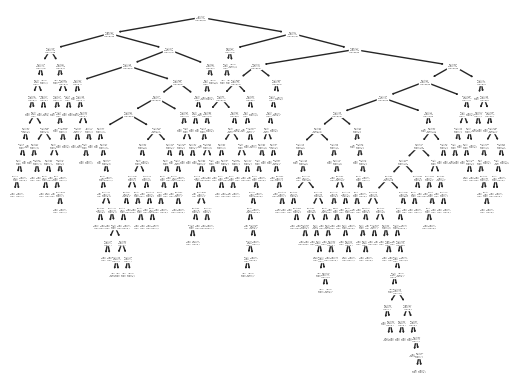

In [36]:
if graphviz_installed:
    export_graphviz(
        decision_tree_classifier, out_file="mytree.dot", feature_names=feature_columns
    )
    with open("mytree.dot") as f:
        dot_graph = f.read()
else:
    print(
        "Graphviz is not installed. You will not be able to visualize the trees using Graphviz."
    )
    print("Generating a text representation of the tree instead:")
    tree.plot_tree(decision_tree_classifier, feature_names=list(feature_columns))

In [37]:
graphviz.Source(dot_graph)

NameError: name 'graphviz' is not defined

**YOUR TURN:** Explore the decision tree and answer the following:
* What feature does the root node split on? sex
* What is the depth of the decision tree (i.e., the length of the longest path from root to leaf)?  22
* Do you think this decision tree is prone to overfitting? Why/why not? Yes, because it is very deep and has many nodes

In [43]:
print(f'Root node splits on: {feature_columns[decision_tree_classifier.tree_.feature[0]]}')
print(f'Depth of the decision tree: {decision_tree_classifier.tree_.max_depth}')

Root node splits on: sex
Depth of the decision tree: 22


To reduce the degree to which this tree is overfit to the training data, we can force the tree to be of some *maximum depth*. This ensures the tree won't be able to just keep generating new layers to properly classify every sample in the training stage (and, thus, presumably generalize better to the test set).

Let's try limiting the max depth to 2 and visualizing the resulting tree.

Graphviz is not installed. You will not be able to visualize the trees using Graphviz.
Displaying a text representation of the tree instead:


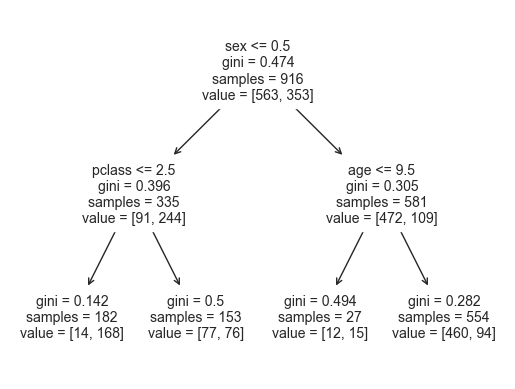

In [44]:
# Define and fit the Decision Tree Classifier with max depth of 2
decision_tree_classifier = tree.DecisionTreeClassifier(max_depth=2)
decision_tree_classifier.fit(X_train, y_train)

# Define feature names
feature_columns = data.columns.drop("survived")

# Visualization code with Graphviz
if graphviz_installed:
    export_graphviz(
        decision_tree_classifier, out_file="mytree.dot", feature_names=feature_columns
    )
    with open("mytree.dot") as f:
        dot_graph = f.read()
else:
    print(
        "Graphviz is not installed. You will not be able to visualize the trees using Graphviz."
    )
    print("Displaying a text representation of the tree instead:")
    tree.plot_tree(decision_tree_classifier, feature_names=feature_columns.tolist())

In [ ]:
graphviz.Source(dot_graph)

Much simpler! As we can see, our model finds Age, Sex, and Pclass to be the most important features. We would expect this model to have much poorer performance when predicting on the training set (as opposed to our 97% we got above), but perhaps better performance on unseen data.

There are many hyper-parameters that can be tuned to change how the model performs. Some common parameters that are modified include:
1. Max Tree Depth: How "tall" do you want your tree to be
2. Minimum Samples Per Leaf: This parameter defines the minimum number of training datapoints that fall into a given leaf node in order for that node to be created
3. Minimum Samples to Split: This parameter controls the minimum number of samples required to create a decision split

To decide the values of each of the parameters, we can use Grid Search combined with cross validation. In Grid Search, we first decide what potential values we want each hyperparameter will take. Then we find every possible combination of parameters and run cross validation on each combination to estimate the performance of that hyperparameter combination.

Luckily, `sklearn` has a nice implementation of Grid Search that runs this algorithm for us. Lets see a demo below:

In [45]:
# Define a Decision Tree Classifier without passing in parameters
decision_tree_model = tree.DecisionTreeClassifier()

# Decide the possible hyperparameter combinations for Grid Search
hyperparameter_grid = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 5, 8, 11],
    "min_samples_leaf": [2, 5, 8, 11],
}

# Define the evaluation metric for Grid Search
evaluation_metric = make_scorer(accuracy_score, greater_is_better=True)

# Set up Grid Search algorithm with a 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=decision_tree_model,
    param_grid=hyperparameter_grid,
    scoring=evaluation_metric,
    cv=5,
)

# Run the Grid Search (Note: This may take a while)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_ * 100:.2f}%")

# Retrieve the best model from the Grid Search
best_model = grid_search.best_estimator_

# Predict on the test data and compute the accuracy
test_accuracy = accuracy_score(
    y_test, best_model.predict(missing_value_imputer.transform(X_test))
)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV Accuracy: 81.55%
Testing Accuracy: 81.17%


In the cell above, we tested our two values per hyperparameter and ran grid search to find the best combination from the space we defined. As you may have noticed, the number of combinations tested by Grid Search exponentially increases as you test more values and tune more hyperparameters. This means that performing a grid search is often a task that takes a long period of time and is often note used for more complex models like neural networks.

### Random Forests, Gradient Boosting, Extreme Gradient Boosting

Let's (briefly) investigate some more advanced tree models that you have learned about and see if we can improve our performance. We will be using the following models in addition to our decision tree classifier:

* Scikitlearn Random Forest classifier
* Scikitlearn Gradient boosting classifier
* XGBoost classifier

Note that XGBoost is similar in theory to Scikitlearn's Gradient boosting classifier. However, XGBoost's implementation is highly efficient than that of Scikitlearn's. Forests are *ensemble* techniques that combine multiple decision trees. As you learned in lecture, and as visualized below, random forest methods usually combine multiple trees through some sort of voting scheme.

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/random-forest.png?raw=1" width="400"/>

In the above example, two trees vote (predict) Class B and another predicts Class A, so the overall ensemble vote goes to the majority (Class B). Boosting, on the other hand, uses multiple trees in in a stage-wise fashion. Popular machine learning software XGBoost has a great explanation for [how this works](https://xgboost.readthedocs.io/en/latest/tutorials/model.html).

Let's build some ensemble classifiers!

In [46]:
decision_tree_classifier = tree.DecisionTreeClassifier()
random_forest_classifier = RandomForestClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()
xgb_classifier = XGBClassifier()

decision_tree_scores = cross_val_score(decision_tree_classifier, X_train, y_train, cv=5)
random_forest_scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=5)
gradient_boosting_scores = cross_val_score(
    gradient_boosting_classifier, X_train, y_train, cv=5
)
xgb_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5)

print(
    f"Decision tree accuracy: {decision_tree_scores.mean():.2f} (+/- {decision_tree_scores.std() * 2:.2f})"
)
print(
    f"Random forest accuracy: {random_forest_scores.mean():.2f} (+/- {random_forest_scores.std() * 2:.2f})"
)
print(
    f"Gradient boosting accuracy: {gradient_boosting_scores.mean():.2f} (+/- {gradient_boosting_scores.std() * 2:.2f})"
)
print(f"XGBoost accuracy: {xgb_scores.mean():.2f} (+/- {xgb_scores.std() * 2:.2f})")

Decision tree accuracy: 0.77 (+/- 0.05)
Random forest accuracy: 0.79 (+/- 0.06)
Gradient boosting accuracy: 0.80 (+/- 0.05)
XGBoost accuracy: 0.79 (+/- 0.09)


We can see that each of the more sophisticated tree/forest methods improves upon the initial decision tree accuracy in terms of cross-validated accuracy.

Let's see how the extreme gradient boosted method performs on the hold-out test set.

In [47]:
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imputer.fit(X_test)
X_test_imputed = imputer.transform(X_test)

xgb_classifier.fit(X_train, y_train)
xgb_accuracy = accuracy_score(y_test, xgb_classifier.predict(X_test_imputed))

print(f"Test set accuracy: {xgb_accuracy * 100:.2f}%")

Test set accuracy: 80.15%


First, we imputed the missing values in the test set (as we had done for the training set) and then we applied our gradient boosting-based classifier (as trained on the training data). We yielded an 80-81% accuracy; not bad!

**YOUR TURN:**
* What features did the gradient boosting algorithm find the most important? Sex, and pclass
* What is the test set accuracy if, instead, you used the Scikitlearn's gradient boosting algorithm? 80.9%

* If you designed a naive classifier that simply guessed 'did not survive' (i.e., Survived = 0) for every row in the test set, how would it perform? 60.6%
* Is this better or worse than our gradient boosted tree? Worse



In [49]:
feature_importances = xgb_classifier.feature_importances_
feature_columns = feature_data.columns

for feature, importance in sorted(
    zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True
):
    print(f"{feature}:\t{importance * 100:.2f}%")
    
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train, y_train)
gradient_boosting_accuracy = accuracy_score(y_test, gradient_boosting_classifier.predict(X_test_imputed))
print(f"GBC accuracy: {gradient_boosting_accuracy * 100:.2f}%")

from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy='constant', constant=0)
dummy_classifier.fit(X_train, y_train)
dummy_accuracy = accuracy_score(y_test, dummy_classifier.predict(X_test_imputed))
print(f"Dummy classifier accuracy: {dummy_accuracy * 100:.2f}%")


sex:	61.08%
pclass:	18.96%
sibsp:	9.14%
fare:	3.96%
age:	3.55%
parch:	3.31%
GBC accuracy: 80.92%
Dummy classifier accuracy: 62.60%


## Bioscience Applications

Decision trees are a popular method in bioscience applications. For example, in the paper [A decision tree-based approach to predicting protein secondary structure content](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC168952/) the authors use decision trees to predict the secondary structure of proteins. In the paper [Decision tree-based method for selecting the best machine learning model for classifying human physical activity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6320913/) the authors use decision trees to classify human physical activity.

Let's take a look at a simple example, using the Pima Indians Diabetes Database. This dataset is a small dataset that contains information about Pima Indians and whether or not they have diabetes. The dataset is available [here](https://www.openml.org/d/37).

In [50]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

diabetes_data = fetch_openml("diabetes", version=1, as_frame=True, parser="auto")
diabetes_data.frame.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [51]:
diabetes_features = diabetes_data.frame.iloc[:, diabetes_data.frame.columns != "class"]
diabetes_target = diabetes_data.frame["class"]
X_train, X_test, y_train, y_test = train_test_split(
    diabetes_features, diabetes_target, test_size=0.3, random_state=0
)

In [52]:
# Create a Decision Tree Classifier
decision_tree_classifier = tree.DecisionTreeClassifier()

# Fit the classifier to the training data
decision_tree_classifier.fit(X_train, y_train)

# Calculate the accuracy on the training set
training_accuracy = accuracy_score(y_train, decision_tree_classifier.predict(X_train))

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, decision_tree_classifier.predict(X_test))

print(f"Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 100.00%
Test Accuracy: 74.46%


In [53]:
# Examine feature importances
feature_importances = decision_tree_classifier.feature_importances_
feature_columns = diabetes_features.columns

In [54]:
for feature, importance in sorted(
    zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True
):
    print(f"{feature}:\t{importance * 100:.2f}%")

plas:	28.61%
age:	18.24%
mass:	13.97%
pedi:	11.77%
pres:	8.75%
preg:	7.19%
skin:	7.18%
insu:	4.29%


## Bonus: Explainability using SHAP

Particularly when we are working with sensitive data, it is important to be able to explain the decisions that our models are making. One way to do this is to use the SHAP (SHapley Additive exPlanations) library. SHAP is a game theoretic approach to explain the output of any machine learning model. SHAP values are used to explain the output of machine learning models by quantifying the contribution of each feature to the prediction. SHAP values have their roots in cooperative game theory where the goal is to fairly distribute the "payout" among the players. In the context of machine learning, the "payout" is the prediction of the model and the "players" are the features. SHAP values are calculated using Shapley values, which is a solution concept from cooperative game theory.

In [55]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [56]:
# Load javascript
shap.initjs()

# Create a SHAP explainer object
explainer = shap.TreeExplainer(decision_tree_classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_train.iloc[0, :])

So what are we looking at here? The force plot shows us the features that are most important for the prediction of the first sample. The red/blue color represents whether the feature is pushing the prediction higher (red) or lower (blue). The value of the feature is shown on the x-axis. The higher the value of the feature, the more it pushes the prediction to the right. The base value is the average prediction of the model. The output value is the prediction of the model for the first sample.

We can also look at the summary plot to see the global importance of each feature.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


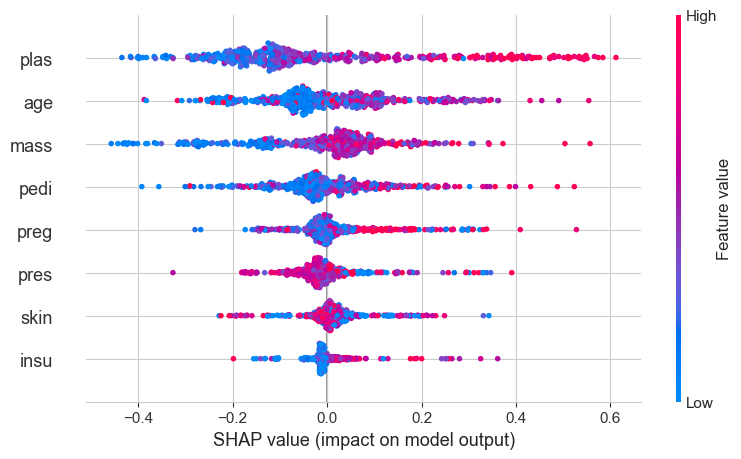

In [57]:
# Show summary plot
shap.initjs()
shap.summary_plot(shap_values[1], X_train)

Here, individual points are plotted based on whether they increase or decrease the value of the final prediction. The colour of each point tells us the value of the feature. For example, the red points have a high value of the feature and the blue points have a low value of the feature. The x-axis shows the impact of the feature on the model output. Features are sorted by the sum of the SHAP value magnitudes across all samples. The y-axis shows the feature name. The features are ordered from the most important to the least important. The colour of the feature represents the value of the feature across all samples.